In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pylab as pl
import os

import shapely.wkt as shpwkt

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA = '../data/'

# Download Census Tract Shape File

In [3]:
url = 'https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile'

if not os.path.isdir(DATA + '/2010CensusTract'):
    print('Download and unzip file...')
    urllib.urlretrieve(url, '2010CensusTract.gz')
    os.system('mv 2010CensusTract.gz ' + DATA)
    os.system('unzip ' + DATA + '2010CensusTract.gz -d ' + DATA + '2010CensusTract')

if os.path.isdir(DATA + '2010CensusTract'):
    for file in os.listdir(DATA + '2010CensusTract'):
        if 'shp' in file:
            print('Shapefile in place..')
            shpfile = file

Shapefile in place..


# Read in data

In [4]:
df = pd.read_csv(DATA + 'yelp.csv')
df.head()

,id,name,alias,cat,categories,geometry,longitude,latitude,address,city,state,zipcode,price,rating,reviews,closed,tr_pickup,tr_delivery,tr_restaurant_reservation,region
0,sCC7-hSdCkNPExejZT9BAQ,The MasalaWala,the-masalawala-new-york-2,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}, {...",POINT (-73.98666 40.72191),-73.986660,40.721910,"[179 Essex St, New York, NY 10002]",New York,NY,10002.0,2.0,4.5,1149,0,1,1,1,asian
1,x0k5kFArHLijdY8-NEQ7Xg,Bengal Tiger Indian Food,bengal-tiger-indian-food-new-york,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-73.977131 40.763167),-73.977131,40.763167,"[58 W 56th St, Fl 2, New York, NY 10019]",New York,NY,10019.0,2.0,4.5,1156,0,1,1,1,asian
2,hevbe9F6sYPguKO5whPSlA,India's Curry,indias-curry-brooklyn-2,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-74.00312 40.60197),-74.003120,40.601970,"[1926 Bath Ave, Brooklyn, NY 11214]",Brooklyn,NY,11214.0,2.0,4.5,34,0,1,1,0,asian
3,lxNU-aBq0yPwBDx-i89ahA,Seva Indian Cuisine,seva-indian-cuisine-astoria-5,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-73.9191014 40.7653633),-73.919101,40.765363,"[3007 34th St, Astoria, NY 11103]",Astoria,NY,11103.0,2.0,4.5,1023,0,1,1,0,asian
4,_7BGw3YFNOTzP1Www3zB7g,Mughlai Grill,mughlai-grill-new-york,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-73.9840446 40.7210905),-73.984045,40.721091,"[6 Clinton St, New York, NY 10002]",New York,NY,10002.0,2.0,5.0,143,0,1,1,0,asian


In [5]:
ct_2010 = gpd.read_file(DATA + '2010CensusTract/' + shpfile)

print(ct_2010.crs)
ct_2010.head()

{'init': 'epsg:4326'}


,puma,boro_ct201,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,geometry
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,9,POLYGON ((-74.07920577013245 40.64343078374567...
1,3808,1009800,009800,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,98,POLYGON ((-73.96432543478758 40.75638153099091...
2,3808,1010000,010000,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,100,POLYGON ((-73.96802436915851 40.75957814005282...
3,3807,1010200,010200,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,102,POLYGON ((-73.97124277307127 40.76093641847906...
4,3807,1010400,010400,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,104,POLYGON ((-73.97445730550224 40.76229308352487...


In [6]:
ct_2010.shape

(2166, 12)

In [7]:
boro_county = {
    'Bronx': '005',
    'Brooklyn': '047',
    'Manhattan': '061',
    'Queens': '081',
    'Staten Island': '085'
}

In [8]:
ct_2010['County'] = ct_2010['boro_name'].map(boro_county)

In [9]:
ct_2010['FIPS'] =  '36' + ct_2010['County'] + ct_2010['ct2010']

### Clean dataframe
There are records with `NaN` longitude and latitude so these need to be dropped first before converting to a GeoDataFrame and doing an `sjoin`.

In [10]:
df.dropna(subset=['longitude', 'latitude'], axis=0, how='any', inplace=True)

df['geometry'] = df['geometry'].apply(lambda x: shpwkt.loads(x))

### Convert to GeoDataFrame

In [11]:
yelp_gdf = gpd.GeoDataFrame(df, geometry='geometry')
yelp_gdf.crs = {'init': 'epsg:4326'}
yelp_gdf.head()

,id,name,alias,cat,categories,geometry,longitude,latitude,address,city,state,zipcode,price,rating,reviews,closed,tr_pickup,tr_delivery,tr_restaurant_reservation,region
0,sCC7-hSdCkNPExejZT9BAQ,The MasalaWala,the-masalawala-new-york-2,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}, {...",POINT (-73.98666 40.72191),-73.986660,40.721910,"[179 Essex St, New York, NY 10002]",New York,NY,10002.0,2.0,4.5,1149,0,1,1,1,asian
1,x0k5kFArHLijdY8-NEQ7Xg,Bengal Tiger Indian Food,bengal-tiger-indian-food-new-york,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-73.977131 40.763167),-73.977131,40.763167,"[58 W 56th St, Fl 2, New York, NY 10019]",New York,NY,10019.0,2.0,4.5,1156,0,1,1,1,asian
2,hevbe9F6sYPguKO5whPSlA,India's Curry,indias-curry-brooklyn-2,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-74.00312 40.60197),-74.003120,40.601970,"[1926 Bath Ave, Brooklyn, NY 11214]",Brooklyn,NY,11214.0,2.0,4.5,34,0,1,1,0,asian
3,lxNU-aBq0yPwBDx-i89ahA,Seva Indian Cuisine,seva-indian-cuisine-astoria-5,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-73.9191014 40.7653633),-73.919101,40.765363,"[3007 34th St, Astoria, NY 11103]",Astoria,NY,11103.0,2.0,4.5,1023,0,1,1,0,asian
4,_7BGw3YFNOTzP1Www3zB7g,Mughlai Grill,mughlai-grill-new-york,Indian,"[{u'alias': u'indpak', u'title': u'Indian'}]",POINT (-73.9840446 40.7210905),-73.984045,40.721091,"[6 Clinton St, New York, NY 10002]",New York,NY,10002.0,2.0,5.0,143,0,1,1,0,asian


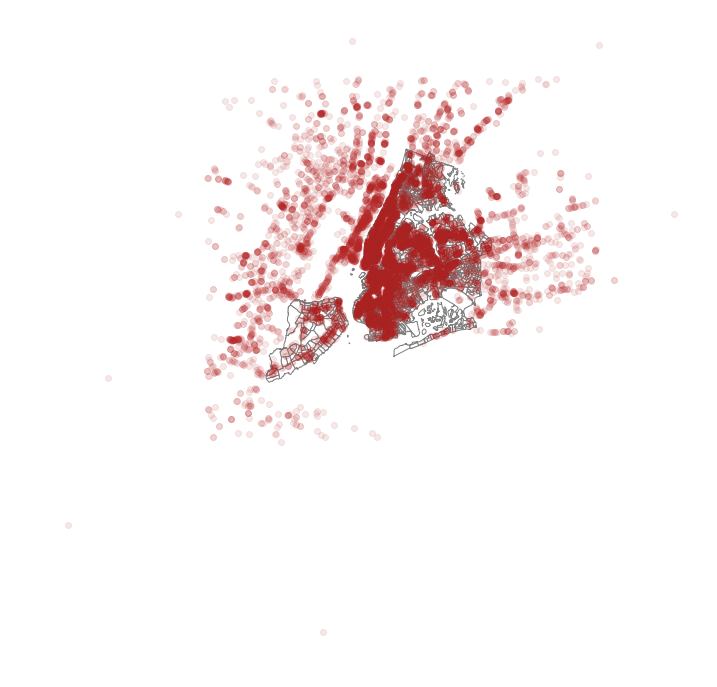

In [12]:
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ct_2010.plot(ax=ax, color='white', edgecolor='gray')
yelp_gdf.plot(ax=ax, c='firebrick', alpha=0.1)
pl.axis('off');

### Figure 1. Yelp Restaurants over NYC Census Tracts
The Yelp Restaurants were retrieved through the Yelp API and the search criteria is based on nearby location. Some restaurants in New Jersey were also included in the results. 

This needs to be cleaned out through a spatial join. Only points within the Census Tract polygons will be considered.

In [13]:
yelp_ct_2010 = gpd.sjoin(yelp_gdf, ct_2010, op='within')
print(yelp_ct_2010.shape)

(11184, 34)


In [14]:
ct_2010.shape

(2166, 14)

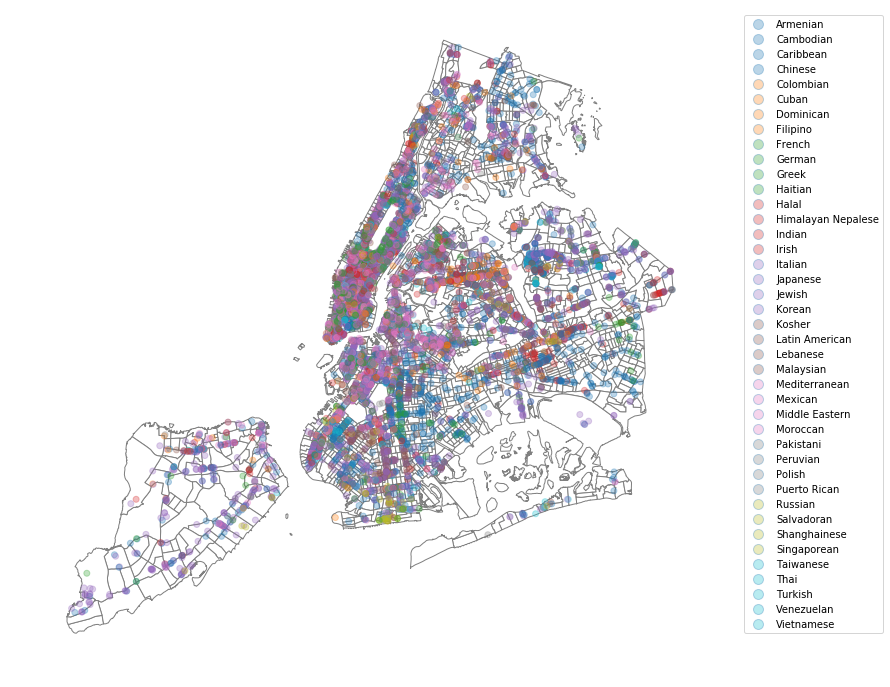

In [15]:
fig = pl.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ct_2010.plot(ax=ax, color='white', edgecolor='gray')
yelp_ct_2010.plot(ax=ax, column='cat', alpha=0.3, legend=True)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.05, 1))
pl.axis('off')
fig.savefig('../data/NYC_restaurants.png', bbox_extra_artists=(legend,), bbox_inches='tight')

### Figure 2. Yelp Restaurants over NYC Census Tracts (Cleaned)
After doing the spatial join, we now only have restaurants that are within the New York City boundaries.

## Create Pivot Table for Counts of Restaurants (Per Census Tract)
Generate the counts per restaurant "region" and "category" for each census tract.

In [16]:
regions = yelp_ct_2010.groupby(['FIPS','region']).count().reset_index()
regions.head()

,FIPS,region,id,name,alias,cat,categories,geometry,longitude,latitude,...,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,County
0,36005000200,asian,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,36005001900,asian,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,36005001900,european,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,36005001900,hispanic,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,36005002000,hispanic,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [17]:
regions.shape

(3431, 34)

In [18]:
regions_pivot = pd.pivot_table(
  regions,values='id',
  index=['FIPS'], #these stay as columns; will fail silently if any of these cols have null values
  columns=['region']) #data values in this column become their own column

regions_pivot.fillna(0, inplace=True)
regions_pivot.reset_index(inplace=True)
regions_pivot.head()

region,FIPS,asian,european,halal,hispanic,midmed
0,36005000200,1.0,0.0,0.0,0.0,0.0
1,36005001900,2.0,2.0,0.0,1.0,0.0
2,36005002000,0.0,0.0,0.0,1.0,0.0
3,36005002500,1.0,0.0,0.0,0.0,0.0
4,36005002701,0.0,0.0,0.0,1.0,0.0


In [19]:
regions_pivot.shape

(1533, 6)

In [20]:
categories = yelp_ct_2010.groupby(['FIPS','cat']).count().reset_index()
categories.head()

,FIPS,cat,id,name,alias,categories,geometry,longitude,latitude,address,...,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,ctlabel,County
0,36005000200,Chinese,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,36005001900,Italian,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,36005001900,Japanese,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,36005001900,Mexican,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,36005001900,Thai,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [21]:
categories.shape

(6290, 34)

In [22]:
categories_pivot = pd.pivot_table(
  categories,values='id',
  index=['FIPS'], #these stay as columns; will fail silently if any of these cols have null values
  columns=['cat']) #data values in this column become their own column

categories_pivot.fillna(0, inplace=True)
categories_pivot.reset_index(inplace=True)
categories_pivot.head()

cat,FIPS,Armenian,Cambodian,Caribbean,Chinese,Colombian,Cuban,Dominican,Filipino,French,...,Puerto Rican,Russian,Salvadoran,Shanghainese,Singaporean,Taiwanese,Thai,Turkish,Venezuelan,Vietnamese
0,36005000200,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36005001900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,36005002000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36005002500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36005002701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
categories_pivot.shape

(1533, 42)

# Get Total Counts of Restaurants Per Census Tract

In [24]:
totals = yelp_ct_2010.groupby('FIPS')['id'].count().reset_index()
totals.columns = ['FIPS', 'Total']
totals.head()

,FIPS,Total
0,36005000200,1
1,36005001900,5
2,36005002000,1
3,36005002500,1
4,36005002701,1


In [25]:
totals.shape

(1533, 2)

# Merge Regions and Categories Counts per Census Tract
Merging the "regions" and "categories" count to one DataFrame and also merging the counts back to the Census Tract shape file.

The merge on the shape file is an outer join to include all census tracts.

In [26]:
yelp_counts = totals.merge(regions_pivot.merge(categories_pivot, on='FIPS'), on='FIPS')
yelp_counts.head()

,FIPS,Total,asian,european,halal,hispanic,midmed,Armenian,Cambodian,Caribbean,...,Puerto Rican,Russian,Salvadoran,Shanghainese,Singaporean,Taiwanese,Thai,Turkish,Venezuelan,Vietnamese
0,36005000200,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36005001900,5,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,36005002000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36005002500,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36005002701,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
yelp_counts = yelp_counts.merge(ct_2010[['FIPS']], on='FIPS', how='outer')
yelp_counts.shape

(2166, 48)

In [28]:
yelp_counts.fillna(0, inplace=True)

In [ ]:
yelp_counts.to_csv(DATA + 'yelp_counts_per_ct.csv')

In [29]:
yelp_counts.shape

(2166, 48)

In [30]:
yelp_shpfile = ct_2010.merge(yelp_counts, on='FIPS', how='outer')
yelp_shpfile.fillna(0, inplace=True)
print(type(yelp_shpfile))
yelp_shpfile.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,puma,boro_ct201,ct2010,ntaname,ntacode,boro_name,shape_leng,shape_area,cdeligibil,boro_code,...,Puerto Rican,Russian,Salvadoran,Shanghainese,Singaporean,Taiwanese,Thai,Turkish,Venezuelan,Vietnamese
0,3903,5000900,000900,West New Brighton-New Brighton-St. George,SI22,Staten Island,7729.016794,2.497010e+06,I,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3808,1009800,009800,Turtle Bay-East Midtown,MN19,Manhattan,5534.199811,1.906016e+06,I,1,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,0.0,1.0
2,3808,1010000,010000,Turtle Bay-East Midtown,MN19,Manhattan,5692.168737,1.860938e+06,I,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3807,1010200,010200,Midtown-Midtown South,MN17,Manhattan,5687.802439,1.860993e+06,I,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3807,1010400,010400,Midtown-Midtown South,MN17,Manhattan,5693.036367,1.864600e+06,I,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [31]:
ct_2010.shape

(2166, 14)

In [ ]:
if not os.path.isdir(DATA + 'YelpCounts'):
    os.system('mkdir ' + DATA +'YelpCounts')
    
if os.path.isdir(DATA + 'YelpCounts'):
    yelp_shpfile.to_file(DATA + 'YelpCounts/yelp_counts_shape.shp')

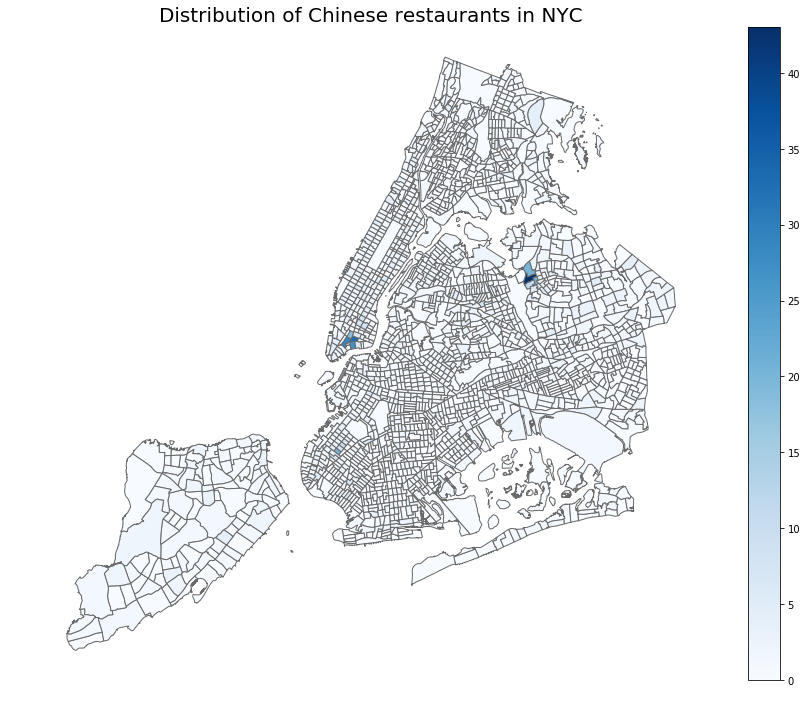

In [38]:
fig = pl.figure(figsize=(15,12))
ax = fig.add_subplot(111)
yelp_shpfile.plot(ax=ax, column='Chinese', cmap='Blues', legend=True, edgecolor='dimgray')
ax.set_title('Distribution of Chinese restaurants in NYC', fontsize=20)
pl.axis('off')
fig.savefig('../data/NYC_Chinese.png');

### Figure 3. Distribution of Chinese restaurants per Census Tract
Just a sample plot to test if the merge was successful.